`THIS NOTEBOOK WAS CREATED BY SOUFIANE` 

- Image preprocessing with openCV
  - Masking
  - Segmentation
  - Reshaping 
  - rescaling 
- Transfer Learning with Keras Pretrained model and Google 
  - VGG16
  - VGG19
  - MobilnetV3 
- Features Extraction
- Applying deep learning model to classify Images 

In [155]:
import os 
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import os
from shutil import copyfile
from keras.applications import vgg16, vgg19
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
#from keras.utils import np_utils, to_categorical
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
import seaborn as sns

In [156]:
data_folder = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/fire_dataset'
train_data_folder = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/fire_dataset/fire_images'
test_date_folder  = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/fire_dataset/non_fire_images'

categories = ['non_fire_images','fire_images']
len_categories = len(categories)

In [157]:

# Définir le répertoire de cache
cache_dir = os.path.expanduser(os.path.join('~', '.keras', 'models'))

# Créer le répertoire de cache s'il n'existe pas
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Spécifier le répertoire contenant les modèles locaux
local_models_dir = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/Keras_pretrained_model'

# Copier les modèles locaux dans le répertoire de cache
for file in os.listdir(local_models_dir):
    if file.startswith('vgg'):
        source = os.path.join(local_models_dir, file)
        destination = os.path.join(cache_dir, file)
        copyfile(source, destination)

# Vérifier que les modèles ont été copiés avec succès
print("Modèles copiés avec succès dans le répertoire de cache :", cache_dir)


Modèles copiés avec succès dans le répertoire de cache : /Users/soufianebelhabibe/.keras/models


In [158]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 195.22it/s]


In [159]:
image_count.keys()

dict_keys(['non_fire_images', 'fire_images'])

In [160]:
print(f"number of fire_images :{len(image_count['fire_images'])}\n number of non_fire_images :{len(image_count['non_fire_images'])} ")

number of fire_images :755
 number of non_fire_images :244 


In [161]:
# create a dataframe 
df = pd.DataFrame(train_data, columns=['file','class','label'])

In [162]:
df.head()

,file,class,label
0,non_fire_images/non_fire.134.png,0,non_fire_images
1,non_fire_images/non_fire.120.png,0,non_fire_images
2,non_fire_images/non_fire.108.png,0,non_fire_images
3,non_fire_images/non_fire.242.png,0,non_fire_images
4,non_fire_images/non_fire.47.png,0,non_fire_images


## Image processing 

In [163]:
# create a mask 
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

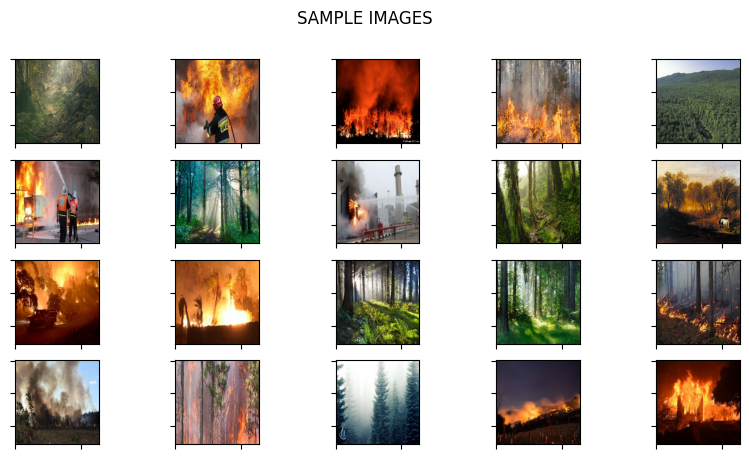

In [164]:
# show image befor processing
nb_rows = 4
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

In [165]:
df['file'][504]

'fire_images/fire.492.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


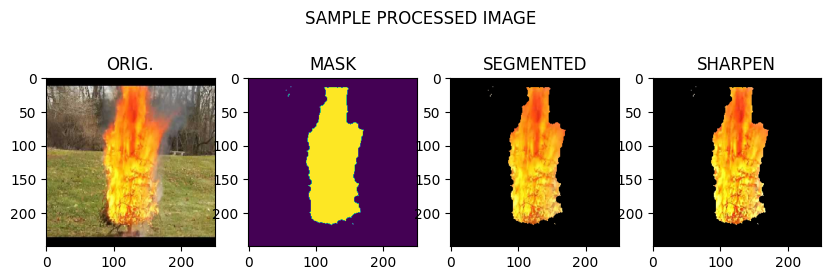

In [166]:
#get an image
img = read_img(df['file'][504],(250,250))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);


In [167]:
'''# prepare image to be procecced by VGG19, The default input size for this model is 224x224.
def create_image(filepath, target_size=(224, 224)):
    img = read_img(filepath, size=target_size)
    img= segment_image(img)
    img = sharpen_image(img)
    # Prétraitement pour VGG19
    img = preprocess_input(img)
    fig 
    return img '''

'# prepare image to be procecced by VGG19, The default input size for this model is 224x224.\ndef create_image(filepath, target_size=(224, 224)):\n    img = read_img(filepath, size=target_size)\n    img= segment_image(img)\n    img = sharpen_image(img)\n    # Prétraitement pour VGG19\n    img = preprocess_input(img)\n    fig \n    return img '

In [168]:
#create_image(df['file'][504], target_size=(224, 224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


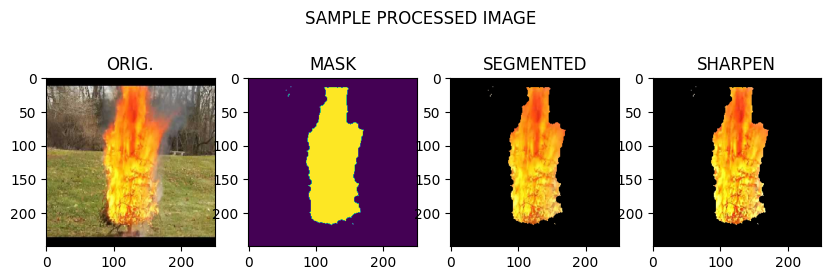

In [170]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

## Transfer tunning with VGG19
[Documentation VGG16 and VGG19](https://keras.io/api/applications/vgg/#vgg19-function)

In [171]:
INPUT_SIZE = 224  # La taille d'entrée par défaut pour VGG19

# Prétraitement de l'entrée
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    # Lire l'image
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    # Segmenter l'image
    image_segmented = segment_image(img)
    # Aiguiser l'image
    image_sharpen = sharpen_image(image_segmented)
    # Prétraiter l'image pour VGG19
    x = preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [00:09, 102.40it/s]


In [172]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 224, 224, 3)
Train Image Size:  150377472


In [175]:
#data spliting 
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [176]:
print(f" x_train shape {X_train.shape}")
print(f" x_val shape {X_test.shape}")

 x_train shape (799, 224, 224, 3)
 x_val shape (200, 224, 224, 3)


In [177]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])

FIRE IMAGES ON TRAINING DATA:  606
NON-FIRE IMAGES ON TRAINING DATA:  193


In [ ]:
vgg_19.layers

In [95]:
vgg_19 = vgg19.VGG19(
    include_top=False,# don't include the existant layer classification 
    weights="imagenet",
    input_shape=(224, 224, 3)
   )
for layer in vgg_19.layers : 
    layer.trainable = False

# add the layer classification to our fire classification

x = vgg_19.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
# Créer un modèle basé sur le modèle VGG19 avec la nouvelle couche de classification
model = Model(inputs=vgg_19.input, outputs=prediction)

In [102]:
vgg_train_x = model.predict(X_train, batch_size=32, verbose=1)
vgg_val_x = model.predict(X_val, batch_size=32, verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step


In [103]:
#print shape of feature and size
print('Train Shape: ', vgg_train_x.shape)
print('Train Size: ', vgg_train_x.size)

print('Validation Shape: ', vgg_val_x.shape)
print('Validation Size: ', vgg_val_x.size)

Train Shape:  (799, 2)
Train Size:  1598
Validation Shape:  (200, 2)
Validation Size:  400


Deep learning model

In [ ]:
#keras Sequential model
model = Sequential()

model.add(Dense(units = 256 , activation = 'relu', input_dim=vgg_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.summary()

history = model.fit(vgg_train_x, y_train, epochs=100, batch_size=32)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

we can see that our model does not realy performed the classification because we putted of the layers of keras pretrained model

In [178]:
Vgg_19 = vgg19.VGG19(
    include_top=True,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling ="avg", 
    classes =1000
)

In [179]:
V_train = Vgg_19.predict(X_train, batch_size=32, verbose=1)
V_test = Vgg_19.predict(X_test, batch_size=32, verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step


In [180]:
#print shape of feature and size
print('Train Shape: ', V_train.shape)
print('Train Size: ', V_train.size)

print('Validation Shape: ', V_test.shape)
print('Validation Size: ', V_test.size)

Train Shape:  (799, 1000)
Train Size:  799000
Validation Shape:  (200, 1000)
Validation Size:  200000


In [181]:
#keras Sequential model
model = Sequential()

model.add(Dense(units = 256 , activation = 'relu', input_dim=V_train.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.summary()

history = model.fit(V_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7721 - loss: 0.6595   
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7593 - loss: 0.5574 
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7599 - loss: 0.5515 
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7534 - loss: 0.5586 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7738 - loss: 0.5353
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.5341 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7774 - loss: 0.5338 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - loss: 0.5598 
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.5547 
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7725 - loss: 0.5374 
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7402 - loss: 0.5728 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

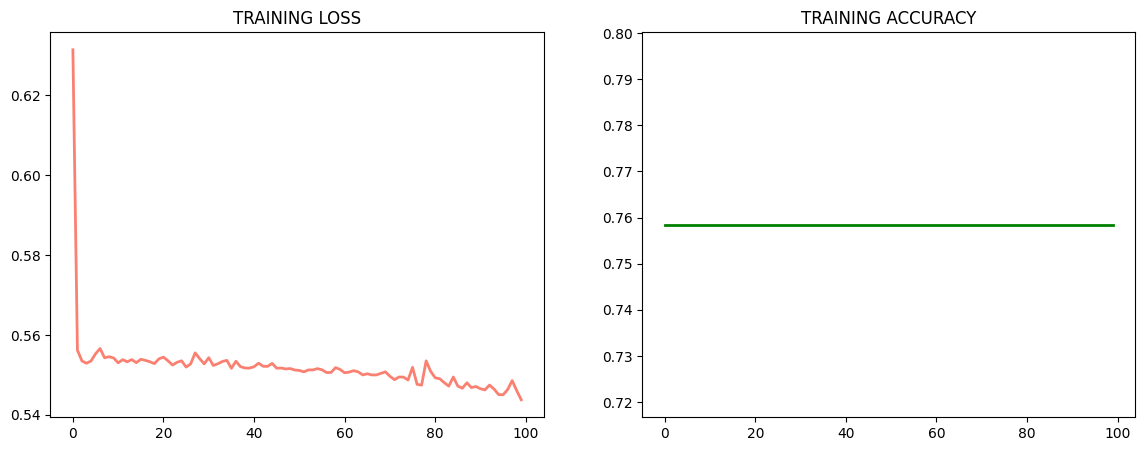

In [182]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [183]:
V_test

array([[0.00011732, 0.0016183 , 0.00051773, ..., 0.00014699, 0.00048456,
        0.00127835],
       [0.00010075, 0.00163448, 0.00056471, ..., 0.00012953, 0.0004445 ,
        0.00149381],
       [0.00012082, 0.00156722, 0.00050969, ..., 0.00014878, 0.00048502,
        0.00121198],
       ...,
       [0.00012117, 0.00156205, 0.00050499, ..., 0.00014909, 0.00048602,
        0.00120668],
       [0.00011546, 0.00159273, 0.00050342, ..., 0.00015048, 0.00049469,
        0.00125393],
       [0.00012215, 0.00162318, 0.0005138 , ..., 0.00015052, 0.00049187,
        0.00123306]], dtype=float32)

In [194]:
y_pred = np.round(model.predict(V_test))
y_pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

Text(33.222222222222214, 0.5, 'PREDICTIONS')

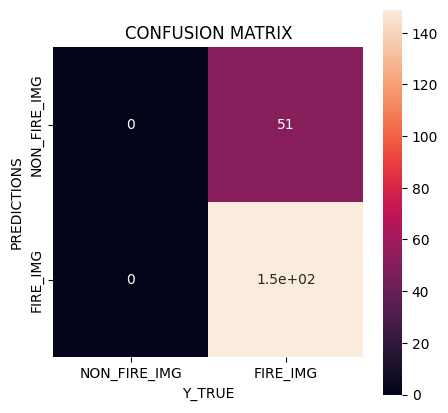

In [197]:
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=[ 'NON_FIRE_IMG','FIRE_IMG'],
            xticklabels=['NON_FIRE_IMG','FIRE_IMG'])
plt.title('CONFUSION MATRIX')
plt.xlabel('Y_TRUE')
plt.ylabel("PREDICTIONS")


on remarque que notre modele considere toute les images comme etant fire_image, on va essayer un autre modele pour comparer les résulatats

## Transfer tunning withn Xception